In [1]:
import os
import numpy
from scipy.misc import logsumexp
import tqdm
import pickle
import hom2m
import wendypy
import wendym2m
from galpy.util import bovy_plot, save_pickles
%pylab inline
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
numpy.random.seed(4)
import copy
import matplotlib.animation as animation
from matplotlib import gridspec
from IPython.display import HTML, Image
import seaborn as sns
from scipy.optimize import curve_fit
tc= sns.color_palette('colorblind')
init_color= sns.color_palette()[0]
final_color= tc[2]
constraint_color= tc[1]
save_figures= True
save_chain_figures= False
_SAVE_GIFS= False
rcParams.update({'axes.labelsize': 17.,
              'font.size': 12.,
              'legend.fontsize': 17.,
              'xtick.labelsize':15.,
              'ytick.labelsize':15.,
              'text.usetex': _SAVE_GIFS,
              'figure.figsize': [5,5],
              'xtick.major.size' : 4,
              'ytick.major.size' : 4,
              'xtick.minor.size' : 2,
              'ytick.minor.size' : 2,
              'legend.numpoints':1})
import copy
numpy.random.seed(2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload
%aimport wendym2m
%aimport hom2m
%autoreload 1

# M2M with one-dimensional self-gravity with an external potential taking into account number/mass density ratio, $X_{nm}$, using the observational constraints of density and $<v^2>$

# Appying to a perturbed disk

Here we investigate M2M with one-dimensional self-gravity and a constant density background, taking into account number/mass density ratio, which is defined with Xnm. We will apply it to a target 1D disk which is perturbed by a vertical impact, similar to a satellite perturbation. 

## Mock observations

First we generate some mock observations for a self-gravitating isothermal disk (a $\mathrm{sech}^2$ disk) with a constant background. Then, we will perturb the disk with a vertical impact. 

A well-known solution of the one-dimensional N-body system is a $\mathrm{sech}^2$ disk. This is the equilibrium distribution for a disk with an isothermal Gaussian velocity distribution (that is, a velocity distribution that is Gaussian with the same dispersion at all locations). Because the equilibrium distribution can only be a function of the energy $E = \Phi(z)+v^2/2$ and the velocity distribution is required to be Gaussian, $f(v) \propto e^{-v^2/[2\sigma^2]}$, the equilibrium distribution function is by necessity:

$f(z,v) = \frac{\rho_0}{\sqrt{2\pi}\,\sigma}\,e^{-E/\sigma^2} = \frac{\rho_0}{\sqrt{2\pi}\,\sigma}\,e^{-\Phi(z)/\sigma^2-v^2/[2\sigma^2]}\,,$

with density

$\rho(z) = \rho_0\,e^{-\Phi(z)/\sigma^2}\,.$

Plugging this density into the Poisson equation allows us to solve for the potential:

$\frac{\mathrm{d}^2\Phi(z)}{\mathrm{d}z^2} = 4\pi G \rho(z) = 4\pi G \rho_0\,e^{-\Phi(z)/\sigma^2}\,,$

which has the solution

$\Phi(z) = 2\sigma^2 \ln\left(\mathrm{cosh}\left[\frac{z}{2 H}\right]\right)\,,$

with $H^2 = \sigma^2/[8\pi G \rho_0]$, because

$\frac{\mathrm{d}\Phi(z)}{\mathrm{d}z} = \frac{2 \sigma^2}{2 H} \frac{\mathrm{sinh}\left[\frac{z}{2 H}\right]}{\mathrm{cosh}\left[\frac{z}{2 H}\right]} = \frac{2 \sigma^2}{2 H}  \mathrm{tanh}\left[\frac{z}{2 H}\right]$, $\frac{\mathrm{d}^2\Phi(z)}{\mathrm{d}z^2} = \frac{2 \sigma^2}{4 H^2} \mathrm{sech}^2\left[\frac{z}{2 H}\right]$

Alternatively, $H = \sigma^2 / [2\pi G \Sigma]$, where $\Sigma$ is the total surface density. The density is then

$\rho(z) = \rho_0\,\mathrm{sech}^2\left(\frac{z}{2H}\right)\,$

and
 
$\Sigma = \int^{\infty}_{-\infty} \rho_0 \mathrm{sech}^2\left[\frac{z}{2 H}\right] dz = 4 H \rho_0$.

## Units

we use units of 2$\pi$G = L(kpc) = V(km/s) = 1. This leads to units of Time$\sim=3.0857\times10^{16}$(s)$=977.9$ Gyr, and Mass$=37005$ M$_{\odot}$.

For the target galaxy, we set $\Sigma=1200.0\sim44$ (M$_{\odot}$pc$^{-2}$) and $\sigma=17.5$ (km/s). 

For an external potential, we consider that in the solar neighborhood dark matter is an approximately constant density $\rho_{\mathrm{DM}} = $ constant.

This density corresponds to a potential $\Phi_{\mathrm{DM}} = \omega^2 z^2 / 2$, with $\omega = \sqrt{4\pi\,G\,\rho_{\mathrm{DM}}}$.

We set $\omega =30.4\sim0.017$ M$_{\odot}$pc$^{-3}$. 

We consider that the observed density is number density of stars, but in M2M model, each element's $w$ traces mass. Here, we assume the number and mass denity ratio of $X_{nm}$, and fit it as well.

In [3]:
n_init = 100000
n_init0 = n_init
sigma_true = 17.5 # Velocity dispersion in the disc 
totmass_true = 1200.0 # Surface density of the disc 
zh_true = sigma_true**2./totmass_true  # Where 2\pi G= 1 so units of zh are ~311 pc
tdyn = zh_true/sigma_true
# external potential
omegadm_true = 30.4
z_init, vz_init, m_init = wendym2m.sample_sech2(
    sigma_true, totmass_true, n=n_init)
print('zh, tdyn, omega_dm =', zh_true, tdyn, omegadm_true)

zh, tdyn, omega_dm = 0.2552083333333333 0.014583333333333332 30.4


We will add the background potential adiabatically.

In [4]:
g = wendypy.nbody(z_init, vz_init, m_init, 0.01*tdyn, approx=True, nleap=1)

In [5]:
nt = 700
zt = numpy.empty((n_init, nt+1))
vzt = numpy.empty((n_init, nt+1))
# Et = numpy.empty((nt+1))
zt[:, 0] = z_init
vzt[:, 0] = vz_init
# Et[0] = wendy.energy(z_init, vz_init, m_init)
# increasing omega
nstep_omega = 500
domega = omegadm_true/nstep_omega
omega_ii = 0.0
tz = z_init
tvz = vz_init
for ii in tqdm.trange(nt):
    if ii <= nstep_omega:
        g = wendypy.nbody(tz, tvz, m_init, 0.01*tdyn, omega=omega_ii, approx=True, nleap=1)
    tz, tvz= next(g)
    zt[:, ii+1] = tz
    vzt[:, ii+1] = tvz
    # Et[ii+1] = wendy.energy(tz, tvz, m_init, omega=omega_ii)
    # update omega
    if ii < nstep_omega:
        omega_ii += domega
z_start= zt[:, -1]
vz_start= vzt[:, -1]
print('Final omega and omega_dm =', omega_ii, omegadm_true)

100%|██████████| 700/700 [00:18<00:00, 37.93it/s]

Final omega and omega_dm = 30.400000000000176 30.4


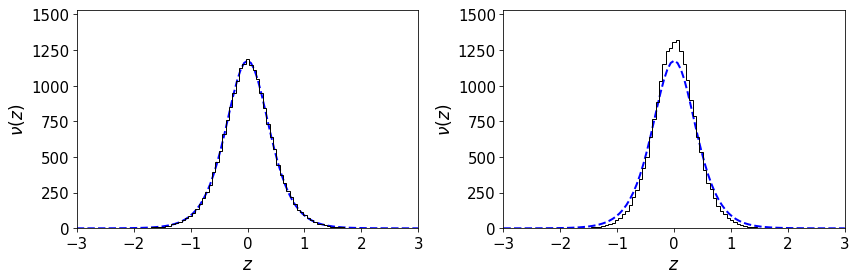

In [6]:
ii = 0
# plot range 
zmin = -3.0
zmax = 3.0
rhomin = 10.**-3.
rhomax = 1.3*totmass_true/(4.0*zh_true)
nbinz = 101
figsize(12,4)
subplot(1,2,1)
_= hist(zt[:,ii], bins=nbinz, histtype='step', lw=1., color='k',
            range=[zmin, zmax],
            weights = numpy.ones(n_init)*(totmass_true/n_init)*nbinz/(zmax-zmin))
zs = numpy.linspace(zmin, zmax, nbinz)
plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
        'b--', lw=2., zorder=0)
xlim(zmin, zmax)
ylim(rhomin, rhomax)
xlabel(r'$z$')
ylabel(r'$\nu(z)$')
subplot(1,2,2)
_= hist(zt[:,nt-1], bins=nbinz, histtype='step', lw=1., color='k',
            range=[zmin, zmax],
            weights = numpy.ones(n_init)*(totmass_true/n_init)*nbinz/(zmax-zmin))
zs = numpy.linspace(zmin, zmax, nbinz)
plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
        'b--', lw=2., zorder=0)
xlim(zmin, zmax)
ylim(rhomin, rhomax)
xlabel(r'$z$')
ylabel(r'$\nu(z)$')

tight_layout()

In [7]:
figsize(6,4)
fig, ax = subplots()
ii = 0
# plot range 
zmin = -3.0
zmax = 3.0
rhomin = 10.**-3.
rhomax = 1.3*totmass_true/(4.0*zh_true)
nbinz = 101
a = ax.hist(zt[:,ii], bins=nbinz, histtype='step', lw=1., color='k',
            range=[zmin, zmax],
            weights = numpy.ones(n_init)*(totmass_true/n_init)*nbinz/(zmax-zmin))
zs = numpy.linspace(zmin, zmax, nbinz)
ax.plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
        'b--', lw=2., zorder=0)
ax.set_xlim(zmin, zmax)
ax.set_ylim(rhomin, rhomax)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\rho(z)$')
ax.set_yscale('log')
ax.annotate(r'$t=0$', (0.95,0.95), xycoords='axes fraction',
            horizontalalignment='right', verticalalignment='top',
            size=18.)
subsamp= 5
def animate(ii):
    ax.clear()
    norm = 1./n_init
    a = ax.hist(zt[:, ii*subsamp], bins=nbinz, histtype='step',
                lw=1., color='k', range=[zmin, zmax],
                weights=numpy.ones(n_init)*(totmass_true/n_init)*nbinz/(zmax-zmin))
    zs = numpy.linspace(zmin, zmax, nbinz)
    ax.plot(zs, 
            totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
    ax.set_xlim(zmin, zmax)
    ax.set_ylim(rhomin, rhomax)
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$\rho(z)$')
    #ax.set_yscale('log')
    ax.annotate(r'$t=%.0f$' % (ii*subsamp/20.),
                (0.95,0.95), xycoords='axes fraction',
                horizontalalignment='right',
                verticalalignment='top', size=18.)
    return a[2]
anim = animation.FuncAnimation(
    fig, animate,#init_func=init_anim_frame,
    frames=nt//subsamp, interval=40, blit=True, repeat=True)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
# save to a file
anim.save("zrho_dmpot.gif", writer= 'imagemagick')
plt.close()
out

After the external potential in introduced, the density profile is more centrally concentrated.

Now we perturb a perturbation by adding a perturber passing through the disk:

In [8]:
nt = 2000
# parameters from Morgan
vz0sat = 20 # The speed of the satellite unit is km/s
pmdisk=0.15  # The mass of the satellite as a percentage of disc mass
msat = totmass_true*pmdisk
#z0sat = max(z_start)*2.
z0sat = -3.0 # The initial location of the satellite from the disk plane (kpc)
# dt = -2*z0sat/vz0sat/(nt) # I choose this time step to make the satellite go from -3 to 3 kpc
dt = 0.02*tdyn
print('dt=', dt)
i_remove = int(round((max(z_start)*1.1-z0sat)/vz0sat/dt))

z = copy.deepcopy(z_start)
vz = copy.deepcopy(vz_start)

# adding the satellite
n_init = n_init0+1
ntot_sat = n_init
z = numpy.append(z, z0sat)
vz = numpy.append(vz, vz0sat)
m = numpy.append(m_init, msat)

print('n_init, msat, i_remove, z size =', n_init, msat, i_remove, numpy.size(m))

dt= 0.00029166666666666664
n_init, msat, i_remove, z size = 100001 180.0 909 100001


In [9]:
zt = numpy.empty((n_init, nt+1))
vzt = numpy.empty((n_init, nt+1))
# Et = numpy.empty((n_init))
zt[:,0] = z
vzt[:,0] = vz
# Et[0] = wendy.energy(z, vz, m, omega=omegadm_true)

g= wendypy.nbody(z, vz, m, dt, omega=omegadm_true, approx=True, nleap=1)

for ii in tqdm.trange(i_remove):
    tz, tvz = next(g)
    tz[-1] = z0sat+ii*dt*vz0sat
    tvz[-1] = vz0sat
    zt[:,ii+1] = tz
    vzt[:,ii+1] = tvz
    # Et[ii+1] = wendy.energy(tz, tvz, m)
    g = wendypy.nbody(tz, tvz, m, dt, omega=omegadm_true, approx=True, nleap=1)
    
g = wendypy.nbody(tz[:-1], tvz[:-1], m[:-1], dt, omega=omegadm_true, approx=True, nleap=5)
for ii in tqdm.trange(nt-i_remove):
    tz, tvz = next(g)
    zt[:-1, ii+i_remove+1] = tz
    vzt[:-1, ii+i_remove+1] = tvz
    # Et[ii+i_remove+1] = wendy.energy(tz, tvz, m[:-1], omega=omegadm_true, twopiG=2.*pi)

100%|██████████| 1091/1091 [01:48<00:00, 10.03it/s]


Adjusting position.

In [10]:
zt_iso1 = array([zt[:, i]-median(zt[:, i]) for i in range(i_remove)])
zt_iso2 = array([zt[:-1, i+i_remove]-median(zt[:-1, i+i_remove]) 
                 for i in range(nt-i_remove+1)])

zt_iso = numpy.zeros((ntot_sat, nt+1))
zt_iso[:, :i_remove] = zt_iso1.T
zt_iso[:-1, i_remove:] = zt_iso2.T
zt_iso[-1, i_remove:] = numpy.nan

In [11]:
n_init = n_init0
figsize(6,4)
fig, ax = subplots()
ii = 0
# plot range 
zmin = -2.0
zmax = 2.0
rhomin = 10.**-3.
rhomax = 1.3*totmass_true/(4.0*zh_true)
nbinz = 101
a = ax.hist(zt_iso[:-1,ii], bins=nbinz, histtype='step', lw=1., color='k',
            range=[zmin, zmax],
            weights = numpy.ones(n_init)*(totmass_true/n_init)*nbinz/(zmax-zmin))
zs = numpy.linspace(zmin, zmax, nbinz)
ax.plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
        'b--', lw=2., zorder=0)
ax.set_xlim(zmin, zmax)
ax.set_ylim(rhomin, rhomax)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\rho(z)$')
ax.set_yscale('log')
ax.annotate(r'$t=0$', (0.95,0.95), xycoords='axes fraction',
            horizontalalignment='right', verticalalignment='top',
            size=18.)
subsamp= 5
def animate(ii):
    ax.clear()
    norm = 1./n_init
    a = ax.hist(zt_iso[:-1, ii*subsamp], bins=nbinz, histtype='step',
                lw=1., color='k', range=[zmin, zmax],
                weights=numpy.ones(n_init)*(totmass_true/n_init)*nbinz/(zmax-zmin))
    zs = numpy.linspace(zmin, zmax, nbinz)
    ax.plot(zs, 
            totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
    ax.set_xlim(zmin, zmax)
    ax.set_ylim(rhomin, rhomax)
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$\rho(z)$')
    #ax.set_yscale('log')
    ax.annotate(r'$t=%.0f$' % (ii*subsamp/20.),
                (0.95,0.95), xycoords='axes fraction',
                horizontalalignment='right',
                verticalalignment='top', size=18.)
    return a[2]
anim = animation.FuncAnimation(
    fig, animate,#init_func=init_anim_frame,
    frames=nt//subsamp, interval=40, blit=True, repeat=True)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
anim.save("zrho_perturb.gif", writer= 'imagemagick')
plt.close()
out

## We will set up the target using at a selected step, cf. step=1000 (t=50).

In [12]:
# selected step
# run 1
# istep = 2000
# run 2
istep = 1800
n_mock = n_init
z_mock = zt_iso[:-1, istep]
vz_mock = vzt[:-1, istep]-numpy.mean(vzt[:-1, istep])
m_mock = m_init
totmass_true = numpy.sum(m_mock)
omegadm = copy.deepcopy(omegadm_true)
print('Totmass =', totmass_true) 

Totmass = 1200.0000000000002


Let's plot z vs. vz

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)



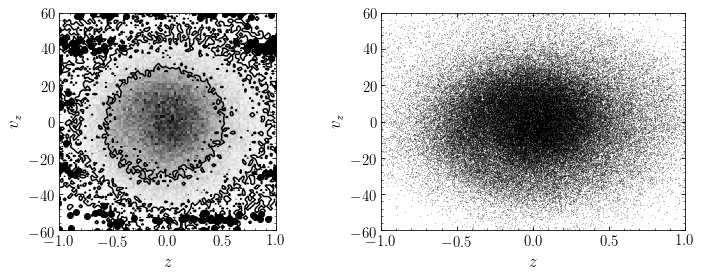

In [13]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.scatterplot(z_mock,vz_mock,'ko',
                   xlabel=r'$z$',ylabel=r'$v_z$',
                   xrange=[-1.0, 1.0],yrange=[-60.0,60.0],gcf=True)
subplot(1,2,2)
# only plot 20% of data
# rnum = numpy.random.rand(len(z_mock))
# z01 = z_mock[rnum<1.0]
# vz01 = vz_mock[rnum<1.0]
bovy_plot.bovy_plot(z_mock,vz_mock,'ko', 0.1,
                   xlabel=r'$z$',ylabel=r'$v_z$',
                   xrange=[-1.0, 1.0],yrange=[-60.0,60.0],gcf=True, markersize=0.1)


Let's plot the density profile. 

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")



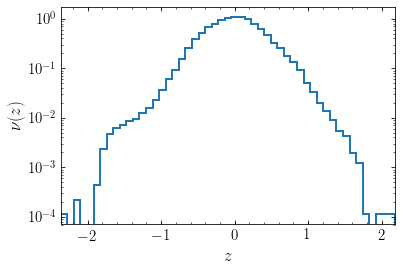

In [14]:
figsize(6,4)
_= bovy_plot.bovy_hist(z_mock,bins=51,normed=True,
                       xlabel=r'$z$',ylabel=r'$\nu(z)$',lw=2.,
                       histtype='step')
gca().set_yscale('log')

Now we 'observe' this density distribution from $z_{\mathrm{sun}} = 0$ and $X_{nm}=0.002$:

In [15]:
zsun_true= 0.0
xnm_true = 0.002
# We only observe the density at a few z
# z_obs= numpy.array([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0,
#                    0. -0.2, -0.4, -0.6, -0.8, -1.0, -1.2,
#                    -1.4, -1.6, -1.8, -2.0])
# z_obs= numpy.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 
#                    0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 
#                    1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 
#                    1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2.0,
#                    -0.05, -0.1, -0.15, -0.2, -0.25, -0.3, -0.35, -0.4, -0.45, -0.5,
#                    -0.55, -0.6, -0.65, -0.7, -0.75, -0.8, -0.85, -0.9, -0.95, -1.0,
#                    -1.05, -1.1, -1.15, -1.2, -1.25, -1.3, -1.35, -1.4, -1.45, -1.5,
#                    -1.55, -1.6, -1.65, -1.7, -1.75, -1.8, -1.85, -1.9, -1.95, -2.0,])
# z_obs= numpy.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
#                      -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0])
# h_obs= 0.1
# z_obs= numpy.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3,
#                     -0.1, -0.3, -0.5, -0.7, -0.9, -1.1, 1.3])
# z_obs= numpy.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9,
#                    2.1, 2.3, 2.5, 2.7, 2.9, 3.1,
#                    -0.1, -0.3, -0.5, -0.7, -0.9, -1.1, -1.3, -1.5, -1.7, -1.9,
#                    -2.1, -2.3, -2.5, -2.7, -2.9, -3.1])
#z_obs= numpy.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9,
#                    -0.1, -0.3, -0.5, -0.7, -0.9, -1.1, -1.3, -1.5, -1.7, -1.9])
# to match with Gaia DR2 BB19 col0
z_obs= numpy.array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65,
                    -0.15, -0.25, -0.35, -0.45, -0.55, -0.65])
h_obs= 0.1
# z_obs= numpy.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 
#                     1.1, 1.2, 1.3, 1.4, 1.5, 
#                    -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0,
#                    -1.1, -1.2, -1.3, -1.4, -1.5])
#h_obs = 0.1
dens_obs= xnm_true*hom2m.compute_dens(z_mock,zsun_true,z_obs,h_obs,w=m_mock)
#dens_obs_noise= numpy.sqrt(dens_obs)*0.2*numpy.sqrt(numpy.amax(dens_obs))\
#     /(numpy.fabs(z_obs**2)/numpy.amin(numpy.fabs(z_obs**2)))
dens_obs_noise= 0.2*dens_obs/numpy.sqrt(dens_obs)
numpy.random.seed(203)
dens_obs+= numpy.random.normal(size=dens_obs.shape)*dens_obs_noise

The observed density is:

<ErrorbarContainer object of 3 artists>

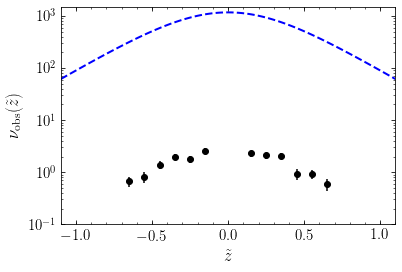

In [16]:
zmin = -1.1
zmax = 1.1
densmin = 0.1
densmax = 1500.0
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,dens_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax], yrange=[densmin, densmax])
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color='k')

We also 'observe' the mean of the squared velocity:

In [17]:
# We only observe the v2 at a few z (same as before)
v2_obs= hom2m.compute_v2(z_mock,vz_mock,zsun_true,z_obs,h_obs)
# use constant noise
# v2_obs_noise=numpy.zeros_like(v2_obs)+0.002
v2_obs_noise=numpy.zeros_like(v2_obs)+20.0
numpy.random.seed(10) # probably best to set a seed somewhere so the data is always the same
v2_obs+= numpy.random.normal(size=v2_obs.shape)*v2_obs_noise

<ErrorbarContainer object of 3 artists>

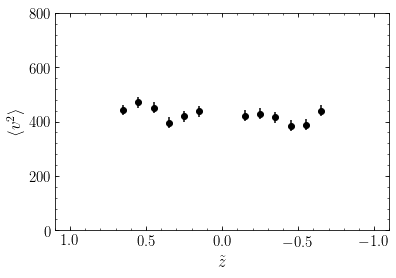

In [18]:
v2min=0.0
v2max = 800.0
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,v2_obs,'ko',
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v^2\rangle$',
                   xrange=[zmax, zmin],yrange=[v2min,v2max],gcf=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color='k')

We also 'observe' the mean velocity:

In [19]:
# We only observe the v2 at a few z (same as before)
v_obs= hom2m.compute_v(z_mock,vz_mock,zsun_true,z_obs,h_obs)
# use constant noise
v_obs_noise=numpy.zeros_like(v_obs)+0.5
numpy.random.seed(42) # probably best to set a seed somewhere so the data is always the same
v_obs+= numpy.random.normal(size=v_obs.shape)*v_obs_noise

<ErrorbarContainer object of 3 artists>

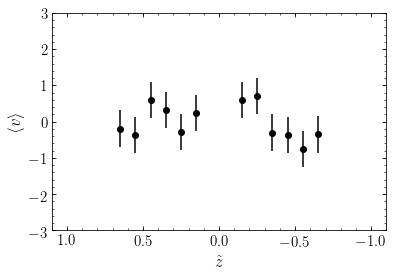

In [20]:
vmin = -3.0
vmax = 3.0
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,v_obs,'ko',
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v\rangle$',
                   xrange=[zmax, zmin],yrange=[vmin, vmax],gcf=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color='k')

Now we fit the density profile with $\mathrm{sech}^2$ profile.

fit parameter a, b, c= [2.68164397 0.24423628 0.00512263]


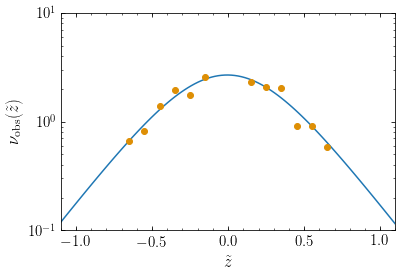

In [21]:
densmin = 0.1
densmax = 10.0
# define sech2 profile
def func_sech2(x, a, b, c):
    return a/(numpy.cosh((x+c)/(2.0*b))**2)
# fit the density with a sech2 profile
popt, pconv = curve_fit(func_sech2, z_obs, dens_obs, bounds=(0, 100))
print('fit parameter a, b, c=', popt)
z_out= numpy.linspace(zmin, zmax, 101)
dens_fit= func_sech2(z_out, *popt)
# plot 
figsize(6,4)
bovy_plot.bovy_plot(z_out, dens_fit,'-',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[densmin, densmax],gcf=True)
bovy_plot.bovy_plot(z_obs, dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
yscale('log',nonposy='clip')

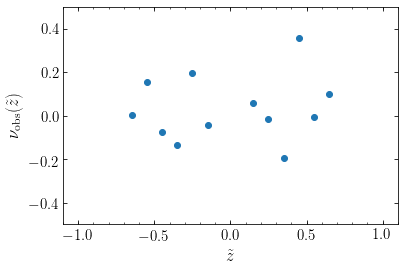

In [22]:
# plot the density differences
dens_fit_obs = func_sech2(z_obs, *popt)
dens_diff = (dens_fit_obs-dens_obs)/dens_obs
# plot 
figsize(6,4)
bovy_plot.bovy_plot(z_obs, dens_diff,'o', color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[-0.5, 0.5],gcf=True)
yscale('linear',nonposy='clip')

Now we load all of this data into the ``data_dicts`` format for specifying the data for M2M:

In [23]:
dens_data= {'type':'dens','pops':0,'zobs':z_obs,'obs':dens_obs,'unc':dens_obs_noise,'zrange':1.}
v2_data= {'type':'v2','pops':0,'zobs':z_obs,'obs':v2_obs,'unc':v2_obs_noise,'zrange':1.}
v_data= {'type':'v','pops':0,'zobs':z_obs,'obs':v_obs,'unc':v_obs_noise,'zrange':1.}
data_dicts= [dens_data,v2_data]
print('zobs=',data_dicts['type'=='dens']['zobs'])

zobs= [ 0.15  0.25  0.35  0.45  0.55  0.65 -0.15 -0.25 -0.35 -0.45 -0.55 -0.65]


## M2M fit

We will fit the density and velocity profiles with Wendy M2M with known $z_{\odot}$ and $\omega_{DM}$.

sigma true = 17.5  model initial = 21.0


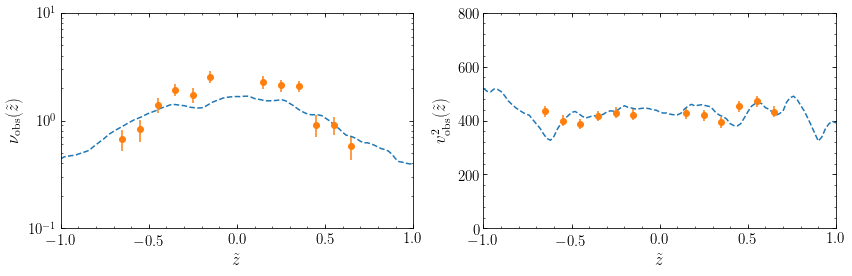

In [86]:
n_m2m= 4000
sigma_init= sigma_true*1.2
print('sigma true =', sigma_true, ' model initial =', sigma_init)
h_m2m= 0.1
z_m2m, vz_m2m, w_init= wendym2m.sample_sech2(sigma_init,totmass_true,n=n_m2m)
z_out= numpy.linspace(zmin, zmax, 101)
dens_init= xnm_true*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
v_init= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
zmin = -1.0
zmax = 1.0
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(z_out,dens_init,'--',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[densmin, densmax])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,2,2)
bovy_plot.bovy_plot(z_out,v2_init,'--',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$v^2_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[v2min, v2max])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])

tight_layout()

We will add the background potential adiabatically.

In [87]:
g = wendypy.nbody(z_m2m, vz_m2m, w_init, 0.01*tdyn, approx=True, nleap=1)
nt = 600
zt = numpy.empty((n_m2m, nt+1))
vzt = numpy.empty((n_m2m, nt+1))
# Et = numpy.empty((nt+1))
zt[:, 0] = z_m2m
vzt[:, 0] = vz_m2m
# Et[0] = wendy.energy(z_init, vz_init, m_init)
# increasing omega
nstep_omega = 500
domega = omegadm_true/nstep_omega
omega_ii = 0.0
tz = z_m2m
tvz = vz_m2m
for ii in tqdm.trange(nt):
    if ii <= nstep_omega:
        g = wendypy.nbody(tz, tvz, w_init, 0.01*tdyn, omega=omega_ii, approx=True, nleap=1)
    tz, tvz= next(g)
    zt[:, ii+1] = tz
    vzt[:, ii+1] = tvz
    # Et[ii+1] = wendy.energy(tz, tvz, m_init, omega=omega_ii)
    # update omega
    if ii < nstep_omega:
        omega_ii += domega
print('Final omega and omega_dm =', omega_ii, omegadm_true)

100%|██████████| 600/600 [00:00<00:00, 1737.78it/s]

Final omega and omega_dm = 30.400000000000176 30.4


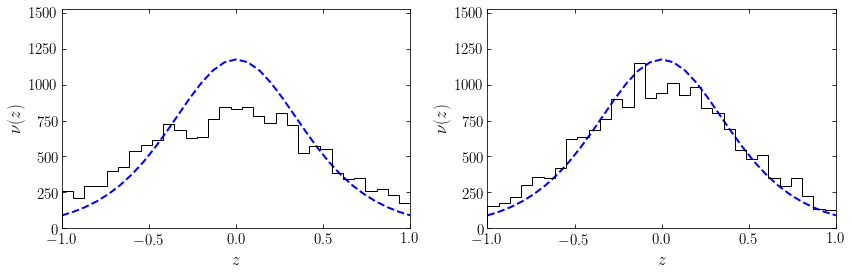

In [88]:
ii = 0
# plot range 
rhomin = 10.**-3.
rhomax = 1.3*totmass_true/(4.0*zh_true)
nbinz = 31
figsize(12,4)
subplot(1,2,1)
_= hist(zt[:,ii], bins=nbinz, histtype='step', lw=1., color='k',
            range=[zmin, zmax],
            weights = numpy.ones(n_m2m)*(totmass_true/n_m2m)*nbinz/(zmax-zmin))
zs = numpy.linspace(zmin, zmax, nbinz)
plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
        'b--', lw=2., zorder=0)
xlim(zmin, zmax)
ylim(rhomin, rhomax)
xlabel(r'$z$')
ylabel(r'$\nu(z)$')
subplot(1,2,2)
_= hist(zt[:,nt], bins=nbinz, histtype='step', lw=1., color='k',
            range=[zmin, zmax],
            weights = numpy.ones(n_m2m)*(totmass_true/n_m2m)*nbinz/(zmax-zmin))
zs = numpy.linspace(zmin, zmax, nbinz)
plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
        'b--', lw=2., zorder=0)
xlim(zmin, zmax)
ylim(rhomin, rhomax)
xlabel(r'$z$')
ylabel(r'$\nu(z)$')

tight_layout()

We will use the final output after adding the DM potential.

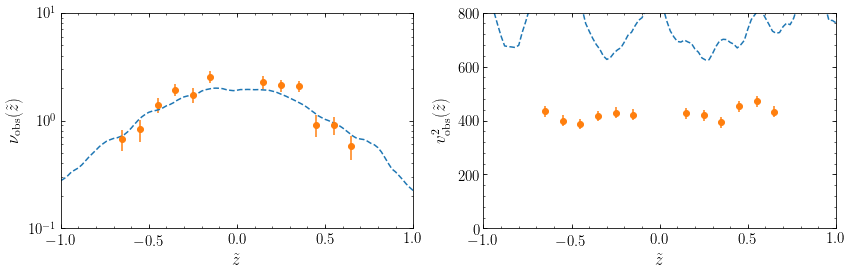

In [89]:
z_m2m = zt[:, nt]
vz_m2m = vzt[:, nt]
z_out= numpy.linspace(zmin, zmax, 101)
dens_init= xnm_true*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
v_init= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(z_out,dens_init,'--',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[densmin, densmax])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,2,2)
bovy_plot.bovy_plot(z_out,v2_init,'--',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$v^2_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[v2min, v2max])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])

tight_layout()

### Run without any smoothing:

In [90]:
# step size for particle integration
step= 0.01*tdyn
nstep= 10000
#eps= 10.**-3.5
eps = 10.0**0.0
smooth= None #1./step/100.
st96smooth= False
mu= 0.0
h_m2m= 0.1
omega_m2m= omegadm_true
zsun_m2m= zsun_true
xnm_m2m = xnm_true
prior= 'entropy'
use_v2=True
w_out,z_m2m,vz_m2m,Q,wevol,windx= \
    wendym2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,data_dicts,npop=1,
                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                     smooth=smooth,st96smooth=st96smooth,output_wevolution=10,
                     number_density=True, xnm_m2m=xnm_m2m)
w_out= w_out[:,0]

 total mass = 1217.233121732029
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")

Velocity dispersions: mock, fit 20.451178581800896 20.874361723545753
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axi

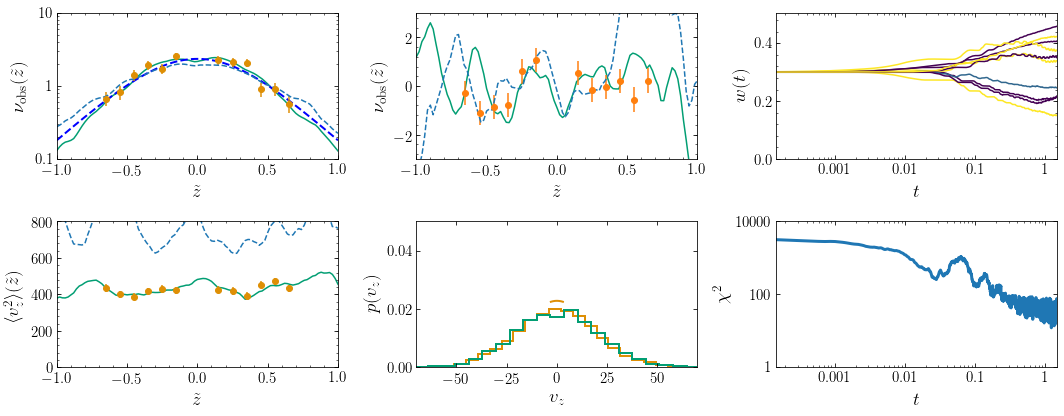

In [91]:
print(' total mass =', numpy.sum(w_out))
z_out= numpy.linspace(zmin, zmax, 101)
dens_final= xnm_m2m*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
v_final= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'--',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[densmin, densmax],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, xnm_true*totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'--',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[zmin, zmax],yrange=[v2min,v2max],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
bovy_plot.bovy_plot(z_out,v_init,'--',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[vmin,vmax])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
bovy_plot.bovy_plot(z_out,v_final,'-',overplot=True,zorder=0,color=final_color)
subplot(2,3,5)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=constraint_color)
xs= numpy.linspace(vmin, vmax, 201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
xlim(-sigma_true*4, sigma_true*4)
ylim(0., 0.05)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
                        color=cm.viridis(z_m2m[windx][ii]/0.3),
                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**4.0])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()

In [92]:
savefilename= 'basic_rhov2obs_data.sav' 
# if os.path.exists(savefilename):
#     with open(savefilename,'rb') as savefile:
#        out= (pickle.load(savefile),)
#        while True:
#            try:
#                out= out+(pickle.load(savefile),)
#            except EOFError:
#                break
#    w_out,z_m2m,vz_m2m,omega_m2m,xnm_m2m,zsun_m2m,data_dicts,w_init= out
#else:
save_pickles(savefilename,w_out,z_m2m,vz_m2m,omegadm_true,xnm_true,zsun_true,totmass_true,
             zh_true,sigma_true,data_dicts,z_mock,vz_mock,v_obs,\
             w_init,h_m2m,omega_m2m,xnm_m2m,zsun_m2m,\
             dens_init,v2_init,v_init,\
             nstep,step,tdyn,eps,Q,wevol,windx)

We can also look at how the fit converges with a movie:

sigma true = 17.5  model initial = 21.0


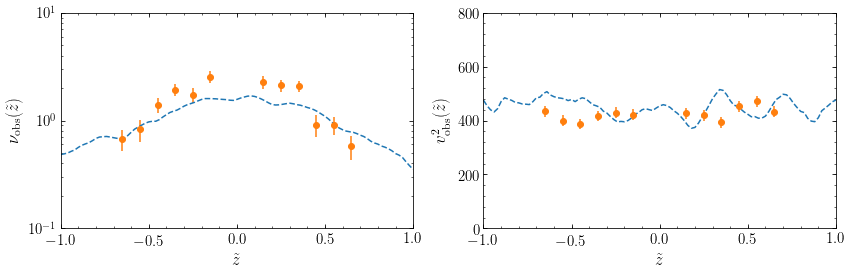

In [99]:
n_m2m= 4000
sigma_init= sigma_true*1.2
print('sigma true =', sigma_true, ' model initial =', sigma_init)
h_m2m= 0.1
z_m2m, vz_m2m, w_init= wendym2m.sample_sech2(sigma_init,totmass_true,n=n_m2m)
z_out= numpy.linspace(zmin, zmax, 101)
dens_init= xnm_true*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
v_init= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(z_out,dens_init,'--',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[densmin, densmax])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,2,2)
bovy_plot.bovy_plot(z_out,v2_init,'--',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$v^2_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[v2min, v2max])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])

tight_layout()

In [100]:
g = wendypy.nbody(z_m2m, vz_m2m, w_init, 0.01*tdyn, approx=True, nleap=1)
nt = 600
zt = numpy.empty((n_m2m, nt+1))
vzt = numpy.empty((n_m2m, nt+1))
# Et = numpy.empty((nt+1))
zt[:, 0] = z_m2m
vzt[:, 0] = vz_m2m
# Et[0] = wendy.energy(z_init, vz_init, m_init)
# increasing omega
nstep_omega = 500
domega = omegadm_true/nstep_omega
omega_ii = 0.0
tz = z_m2m
tvz = vz_m2m
for ii in tqdm.trange(nt):
    if ii <= nstep_omega:
        g = wendypy.nbody(tz, tvz, w_init, 0.01*tdyn, omega=omega_ii, approx=True, nleap=1)
    tz, tvz= next(g)
    zt[:, ii+1] = tz
    vzt[:, ii+1] = tvz
    # Et[ii+1] = wendy.energy(tz, tvz, m_init, omega=omega_ii)
    # update omega
    if ii < nstep_omega:
        omega_ii += domega
print('Final omega and omega_dm =', omega_ii, omegadm_true)

100%|██████████| 600/600 [00:00<00:00, 1773.78it/s]

Final omega and omega_dm = 30.400000000000176 30.4


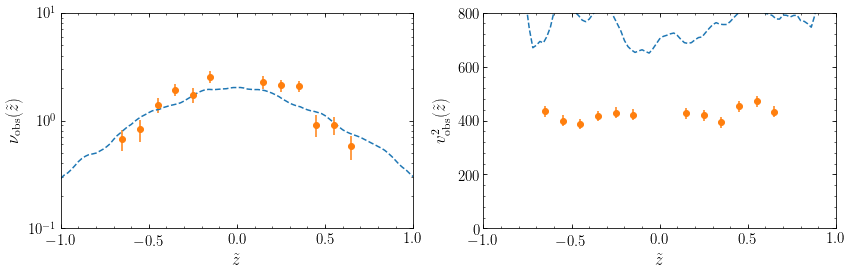

In [101]:
z_m2m = zt[:, nt]
vz_m2m = vzt[:, nt]
z_out= numpy.linspace(zmin, zmax, 101)
dens_init= xnm_true*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
v_init= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(z_out,dens_init,'--',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[densmin, densmax])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,2,2)
bovy_plot.bovy_plot(z_out,v2_init,'--',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$v^2_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[v2min, v2max])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])

tight_layout()

In [102]:
# Require output of position and velocity...
step= 0.01*tdyn
nstep= 10000
# eps= 10.**-3.5
eps = 10.0**0.0
smooth= None #1./step/100.
st96smooth= False
mu= 0.0
h_m2m= 0.1
omega_m2m= omegadm_true
zsun_m2m= zsun_true
prior= 'entropy'
use_v2=True
w_out,z_m2m,vz_m2m,Q,wevol,windx, zevol, vzevol = \
    wendym2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,data_dicts,npop=1,
                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                     smooth=smooth,st96smooth=st96smooth,output_wevolution=len(w_init),
                     output_zvzevolution=len(w_init), number_density=True, xnm_m2m=xnm_m2m)

 total mass = 1220.2864530403267
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")

Velocity dispersions: mock, fit 20.451178581800896 20.88156869678962
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axi

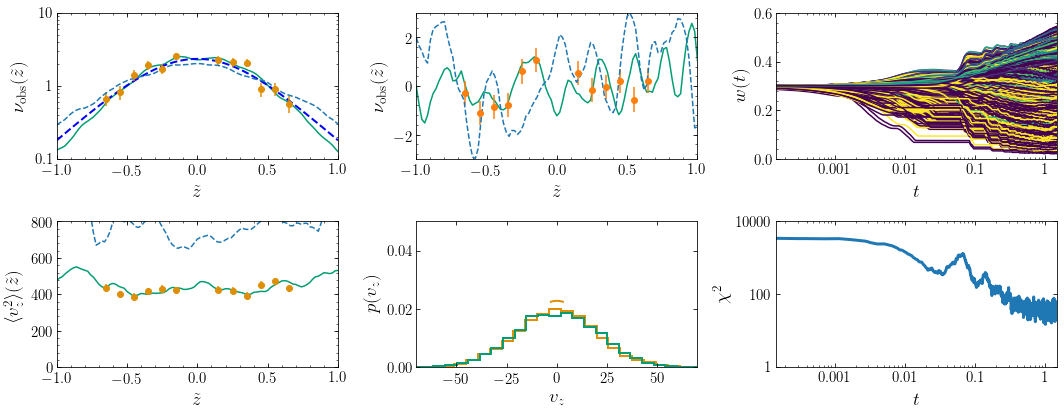

In [103]:
w_out= w_out[:,0]
print(' total mass =', numpy.sum(w_out))
z_out= numpy.linspace(zmin, zmax, 101)
dens_final= xnm_m2m*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
v_final= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'--',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[densmin, densmax],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, xnm_true*totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'--',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[zmin, zmax],yrange=[v2min,v2max],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
bovy_plot.bovy_plot(z_out,v_init,'--',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[vmin,vmax])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
bovy_plot.bovy_plot(z_out,v_final,'-',overplot=True,zorder=0,color=final_color)
subplot(2,3,5)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=constraint_color)
xs= numpy.linspace(vmin, vmax, 201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
xlim(-sigma_true*4, sigma_true*4)
ylim(0., 0.05)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
for ii in range(10):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
                        color=cm.viridis(z_m2m[windx][ii]/0.3),
                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**4.0])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()

In [106]:
### figsize(12,3)
fig, (ax1, ax2, ax3) = pyplot.subplots(1,3)
subplot(1,3,1)
line1, = pyplot.plot([],[],lw=2)
subplot(1,3,2)
line2, = pyplot.plot([],[],lw=2)
subplot(1,3,3)
line3, = pyplot.plot([],[],lw=2)
line= [line1,line2,line3]
subplots_adjust(wspace=.4)
def init_anim_frame():
    subplot(1,3,1)
    line1= bovy_plot.bovy_plot(
        z_out,dens_init,'--',semilogy=True,color=init_color,
        xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
        xrange=[zmin, zmax],yrange=[densmin, densmax],gcf=True)
    line2= bovy_plot.bovy_plot(
        z_obs, dens_obs, 'o', semilogy=True, overplot=True, color=constraint_color)
    line3= errorbar(
        z_obs, dens_obs, yerr=dens_obs_noise, marker='None',
        ls='none', color=constraint_color)
    subplot(1,3,2)
    line4= bovy_plot.bovy_plot(
        z_out, v2_init, '--', color=init_color,
        xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle$',
        xrange=[zmin, zmax],yrange=[v2min, v2max],gcf=True)
    line5= bovy_plot.bovy_plot(z_obs, v2_obs, 'o', overplot=True, color=constraint_color)
    line6= errorbar(
        z_obs, v2_obs, yerr=v2_obs_noise, marker='None', ls='none',color=constraint_color)
    subplot(1,3,3)
    line7= bovy_plot.bovy_plot(
        z_out, v_init, '--', color=init_color,
        xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z\rangle$',
        xrange=[zmin, zmax],yrange=[vmin, vmax],gcf=True)
    line8= bovy_plot.bovy_plot(z_obs, v_obs, 'o', overplot=True, color=constraint_color)
    line9= errorbar(
        z_obs, v_obs, yerr=v_obs_noise, marker='None', ls='none',color=constraint_color)
    return (line1[0],line2[0],line3[0],line4[0],line5[0],line6[0],line7[0],line8[0],line9[0])

subsamp= 20
ipop = 0
def animate(ii):
    # ax.clear()
    dens_final = xnm_m2m*hom2m.compute_dens(zevol[:, ii*subsamp], zsun_true, z_out, h_m2m, w=wevol[:, ipop, ii*subsamp])
    line[0].set_data(z_out, dens_final)
    line[0].set_color(color=final_color)
    v2_final = hom2m.compute_v2(zevol[:, ii*subsamp], vzevol[:, ii*subsamp], zsun_true, z_out,
                                h_m2m, w=wevol[:, ipop, ii*subsamp])
    line[1].set_data(z_out, v2_final)
    line[1].set_color(color=final_color)
    v_final = hom2m.compute_v(zevol[:, ii*subsamp], vzevol[:, ii*subsamp], zsun_true, z_out,
                                h_m2m, w=wevol[:, ipop, ii*subsamp])
    line[2].set_data(z_out, v_final)
    line[2].set_color(color=final_color)
    return line
anim = animation.FuncAnimation(
    fig, animate, init_func=init_anim_frame,
    frames=nstep//subsamp, interval=80, blit=True, repeat=True)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
anim.save("rhovv_m2m.gif", writer= 'imagemagick')
plt.close()
out

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "

/Users/dkawata/anaconda3/lib/python3.6/site-packages/mat

## Fitting for $X_{nm}$

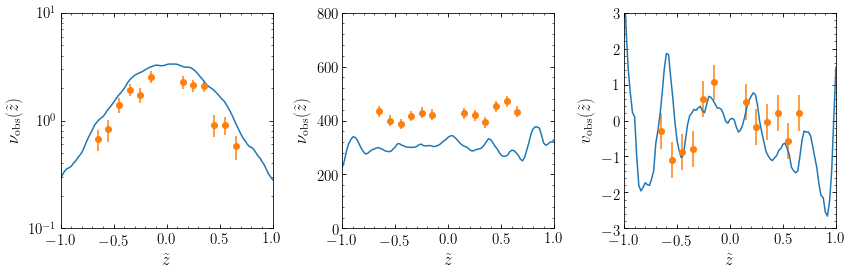

In [112]:
n_m2m= 4000
sigma_init= sigma_true
h_m2m= 0.1
# set a wrong Xnm
xnm_m2m = 1.5*xnm_true
zsun_m2m= zsun_true
omega_m2m = omegadm_true
z_m2m, vz_m2m, w_init= wendym2m.sample_sech2(sigma_init,totmass_true,n=n_m2m)
z_out= numpy.linspace(zmin, zmax, 101)
dens_init= xnm_m2m*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
v_init= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[densmin, densmax])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,3,2)
bovy_plot.bovy_plot(z_out,v2_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[v2min, v2max])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
tight_layout()
subplot(1,3,3)
bovy_plot.bovy_plot(z_out,v_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$v_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[vmin,vmax])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
tight_layout()

In [113]:
g = wendypy.nbody(z_m2m, vz_m2m, w_init, 0.01*tdyn, approx=True, nleap=1)
nt = 600
zt = numpy.empty((n_m2m, nt+1))
vzt = numpy.empty((n_m2m, nt+1))
# Et = numpy.empty((nt+1))
zt[:, 0] = z_m2m
vzt[:, 0] = vz_m2m
# Et[0] = wendy.energy(z_init, vz_init, m_init)
# increasing omega
nstep_omega = 500
domega = omega_m2m/nstep_omega
omega_ii = 0.0
tz = z_m2m
tvz = vz_m2m
for ii in tqdm.trange(nt):
    if ii <= nstep_omega:
        g = wendypy.nbody(tz, tvz, w_init, 0.01*tdyn, omega=omega_ii, approx=True, nleap=1)
    tz, tvz= next(g)
    zt[:, ii+1] = tz
    vzt[:, ii+1] = tvz
    # Et[ii+1] = wendy.energy(tz, tvz, m_init, omega=omega_ii)
    # update omega
    if ii < nstep_omega:
        omega_ii += domega
print('Final omega and omega_dm =', omega_ii, omega_m2m)

100%|██████████| 600/600 [00:00<00:00, 1923.69it/s]

Final omega and omega_dm = 30.400000000000176 30.4


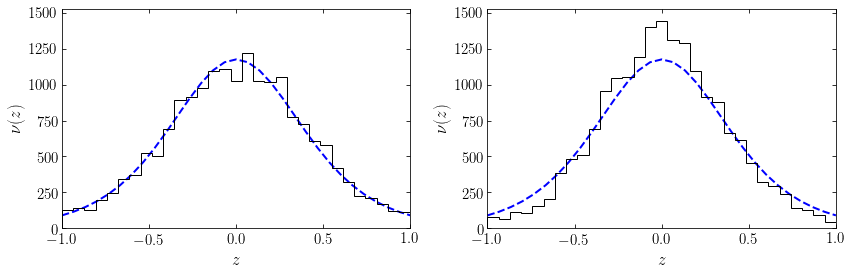

In [114]:
ii = 0
# plot range 
rhomin = 10.**-3.
rhomax = 1.3*totmass_true/(4.0*zh_true)
nbinz = 31
figsize(12,4)
subplot(1,2,1)
_= hist(zt[:,ii], bins=nbinz, histtype='step', lw=1., color='k',
            range=[zmin, zmax],
            weights = numpy.ones(n_m2m)*(totmass_true/n_m2m)*nbinz/(zmax-zmin))
zs = numpy.linspace(zmin, zmax, nbinz)
plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
        'b--', lw=2., zorder=0)
xlim(zmin, zmax)
ylim(rhomin, rhomax)
xlabel(r'$z$')
ylabel(r'$\nu(z)$')
subplot(1,2,2)
_= hist(zt[:,nt], bins=nbinz, histtype='step', lw=1., color='k',
            range=[zmin, zmax],
            weights = numpy.ones(n_m2m)*(totmass_true/n_m2m)*nbinz/(zmax-zmin))
zs = numpy.linspace(zmin, zmax, nbinz)
plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
        'b--', lw=2., zorder=0)
xlim(zmin, zmax)
ylim(rhomin, rhomax)
xlabel(r'$z$')
ylabel(r'$\nu(z)$')

tight_layout()

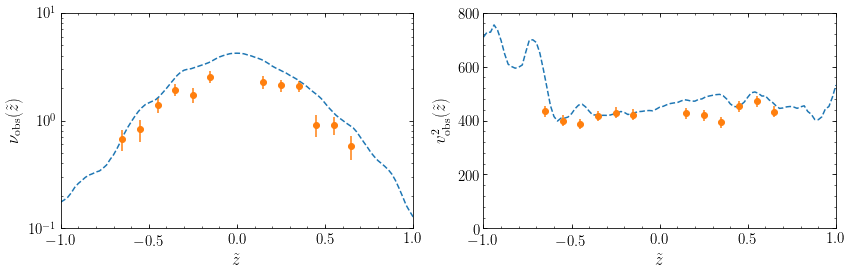

In [115]:
z_m2m = zt[:, nt]
vz_m2m = vzt[:, nt]
z_out= numpy.linspace(zmin, zmax, 101)
dens_init= xnm_m2m*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
v_init= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(z_out,dens_init,'--',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[densmin, densmax])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,2,2)
bovy_plot.bovy_plot(z_out,v2_init,'--',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$v^2_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[v2min, v2max])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])

tight_layout()

In [116]:
# step size for particle integration
step= 0.01*tdyn
nstep= 4000
#eps= 10.**-3.5
eps = [10.0**0.0, 10.0**-8.0]
smooth= None #1./step/100.
st96smooth= False
mu= 0.
h_m2m= 0.1
fit_omega = False
skipomega= 10
skipxnm = 10
fit_xnm = True
prior= 'entropy'
use_v2=True
w_out,xnm_out,z_m2m,vz_m2m,Q,wevol,windx= \
    wendym2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,data_dicts,npop=1,
                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                     smooth=smooth,st96smooth=st96smooth,output_wevolution=10,
                     number_density=True, xnm_m2m=xnm_m2m, fit_xnm=fit_xnm, skipxnm=skipxnm)
w_out= w_out[:,0]

 total mass = 1199.6061452303493
 Xnm =  0.0021098222598038684
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")

Velocity dispersions: mock, fit 20.451178581800896 20.238439734672287
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positiv

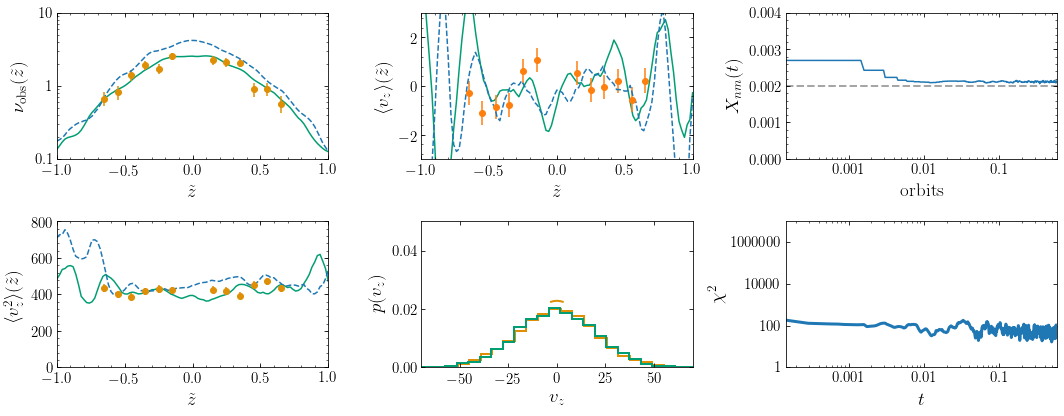

In [118]:
print(' total mass =', numpy.sum(w_out))
print(' Xnm = ', xnm_out[-1])
z_out= numpy.linspace(zmin, zmax, 101)
dens_final= xnm_out[-1]*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
v_final= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'--',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[densmin,densmax],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'--',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[zmin, zmax],yrange=[v2min,v2max],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
#_= hist(w_init,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
# _= hist(w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=final_color)
bovy_plot.bovy_plot(z_out,v_init,'--',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$$\langle v_z\rangle(\tilde{z})$$',
                   xrange=[zmin, zmax],yrange=[vmin,vmax])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
bovy_plot.bovy_plot(z_out,v_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
subplot(2,3,5)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=constraint_color)
xs= numpy.linspace(vmin, vmax, 201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
xlim(-sigma_true*4, sigma_true*4)
ylim(0., 0.05)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,xnm_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[0.,xnm_true*2.0],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$X_{nm}(t)$',gcf=True)
axhline(xnm_true,ls='--',color='0.65',lw=2.,zorder=0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
# for ii in range(len(wevol)):
#    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
#                        color=cm.viridis(z_m2m[windx][ii]/0.3),
#                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
#                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
#gca().xaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**7.0])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()

In [119]:
savefilename= 'xnm_rhov2obs_data.sav' 
# if os.path.exists(savefilename):
#     with open(savefilename,'rb') as savefile:
#        out= (pickle.load(savefile),)
#        while True:
#            try:
#                out= out+(pickle.load(savefile),)
#            except EOFError:
#                break
#    w_out,z_m2m,vz_m2m,omega_m2m,xnm_m2m,zsun_m2m,data_dicts,w_init= out
#else:
save_pickles(savefilename,w_out,omega_out,xnm_out,z_m2m,vz_m2m,omegadm_true,xnm_true,zsun_true,
                 data_dicts,w_init)

NameError: name 'omega_out' is not defined

## Fitting for $\omega$ only

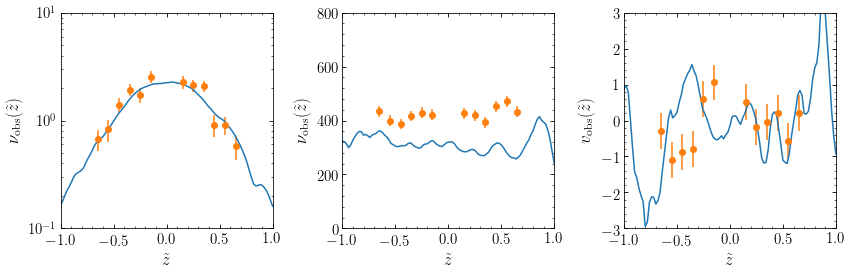

In [164]:
n_m2m= 4000
sigma_init= sigma_true
h_m2m= 0.1
xnm_m2m = xnm_true
# set a wrong omega
omega_m2m = 0.75*omegadm_true
zsun_m2m= zsun_true
z_m2m, vz_m2m, w_init= wendym2m.sample_sech2(sigma_init,totmass_true,n=n_m2m)
z_out= numpy.linspace(zmin, zmax, 101)
dens_init= xnm_m2m*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
v_init= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[densmin, densmax])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,3,2)
bovy_plot.bovy_plot(z_out,v2_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[v2min,v2max])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
tight_layout()
subplot(1,3,3)
bovy_plot.bovy_plot(z_out,v_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$v_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[vmin,vmax])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
tight_layout()

In [165]:
g = wendypy.nbody(z_m2m, vz_m2m, w_init, 0.01*tdyn, approx=True, nleap=1)
nt = 600
zt = numpy.empty((n_m2m, nt+1))
vzt = numpy.empty((n_m2m, nt+1))
# Et = numpy.empty((nt+1))
zt[:, 0] = z_m2m
vzt[:, 0] = vz_m2m
# Et[0] = wendy.energy(z_init, vz_init, m_init)
# increasing omega
nstep_omega = 500
domega = omega_m2m/nstep_omega
omega_ii = 0.0
tz = z_m2m
tvz = vz_m2m
for ii in tqdm.trange(nt):
    if ii <= nstep_omega:
        g = wendypy.nbody(tz, tvz, w_init, 0.01*tdyn, omega=omega_ii, approx=True, nleap=1)
    tz, tvz= next(g)
    zt[:, ii+1] = tz
    vzt[:, ii+1] = tvz
    # Et[ii+1] = wendy.energy(tz, tvz, m_init, omega=omega_ii)
    # update omega
    if ii < nstep_omega:
        omega_ii += domega
print('Final omega and omega_dm =', omega_ii, omegadm_true)

100%|██████████| 600/600 [00:00<00:00, 1767.33it/s]

Final omega and omega_dm = 22.80000000000012 30.4


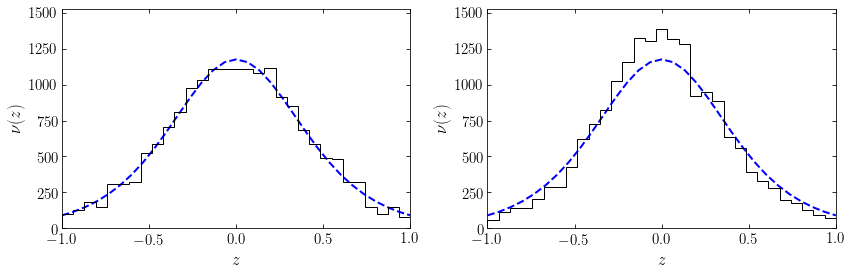

In [166]:
ii = 0
# plot range 
rhomin = 10.**-3.
rhomax = 1.3*totmass_true/(4.0*zh_true)
nbinz = 31
figsize(12,4)
subplot(1,2,1)
_= hist(zt[:,ii], bins=nbinz, histtype='step', lw=1., color='k',
            range=[zmin, zmax],
            weights = numpy.ones(n_m2m)*(totmass_true/n_m2m)*nbinz/(zmax-zmin))
zs = numpy.linspace(zmin, zmax, nbinz)
plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
        'b--', lw=2., zorder=0)
xlim(zmin, zmax)
ylim(rhomin, rhomax)
xlabel(r'$z$')
ylabel(r'$\nu(z)$')
subplot(1,2,2)
_= hist(zt[:,nt], bins=nbinz, histtype='step', lw=1., color='k',
            range=[zmin, zmax],
            weights = numpy.ones(n_m2m)*(totmass_true/n_m2m)*nbinz/(zmax-zmin))
zs = numpy.linspace(zmin, zmax, nbinz)
plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
        'b--', lw=2., zorder=0)
xlim(zmin, zmax)
ylim(rhomin, rhomax)
xlabel(r'$z$')
ylabel(r'$\nu(z)$')

tight_layout()

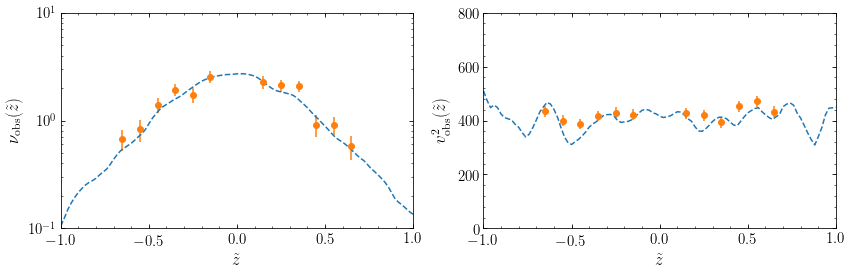

In [167]:
z_m2m = zt[:, nt]
vz_m2m = vzt[:, nt]
z_out= numpy.linspace(zmin, zmax, 101)
dens_init= xnm_m2m*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
v_init= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(z_out,dens_init,'--',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[densmin, densmax])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,2,2)
bovy_plot.bovy_plot(z_out,v2_init,'--',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$v^2_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[v2min, v2max])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])

tight_layout()

In [168]:
# step size for particle integration
step= 0.01*tdyn
nstep= 10000
#eps= 10.**-3.5
eps = [10.0**0.0, 10.0**3.0]
smooth= None #1./step/100.
st96smooth= False
mu= 0.0
h_m2m= 0.2
fit_omega = True
skipomega= 10
fit_xnm = False
prior= 'entropy'
use_v2=True
w_out,omega_out,z_m2m,vz_m2m,Q,wevol,windx= \
    wendym2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,data_dicts,npop=1,
                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                     smooth=smooth,st96smooth=st96smooth,output_wevolution=10,
                     fit_omega=fit_omega,skipomega=skipomega,
                     number_density=True, xnm_m2m=xnm_m2m, fit_xnm=fit_xnm)
w_out= w_out[:,0]

 total mass = 1229.8213465224908
 omega true and fit=  30.4 31.418885036954148
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")

Velocity dispersions: mock, fit 20.451178581800896 20.212929140481343
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to

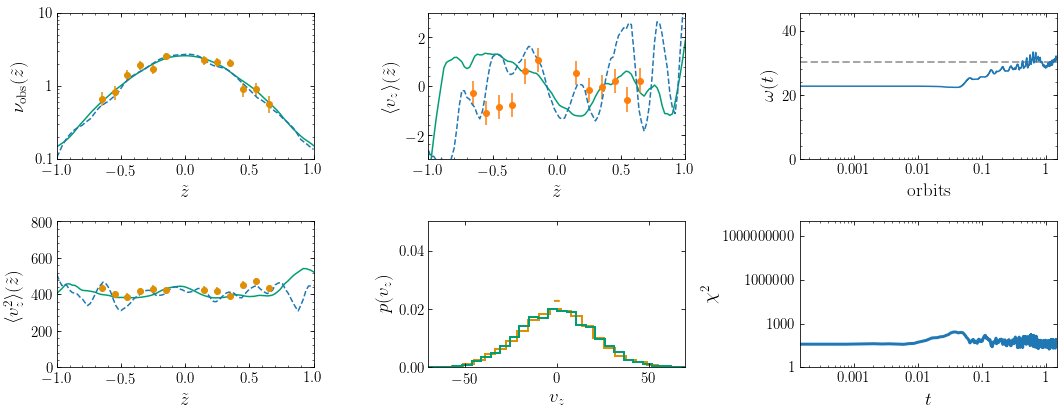

In [169]:
print(' total mass =', numpy.sum(w_out))
print(' omega true and fit= ', omegadm_true, omega_out[-1])
z_out= numpy.linspace(zmin, zmax, 101)
dens_final= xnm_m2m*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
v_final= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'--',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[densmin, densmax],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'--',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[zmin, zmax],yrange=[v2min, v2max],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
#_= hist(w_init,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
bovy_plot.bovy_plot(z_out,v_init,'--',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$$\langle v_z\rangle(\tilde{z})$$',
                   xrange=[zmin, zmax],yrange=[vmin, vmax])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
bovy_plot.bovy_plot(z_out,v_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
subplot(2,3,5)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=constraint_color)
xs= numpy.linspace(zmin, zmax, 201)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
     lw=2.,zorder=2,color=constraint_color)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
xlim(-sigma_true*4.0, sigma_true*4.0)
ylim(0.,0.05)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
# omega evolution
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,omega_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[0.,omegadm_true*1.5],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\omega(t)$',gcf=True)
axhline(omegadm_true,ls='--',color='0.65',lw=2.,zorder=0)
gca().xaxis.set_major_formatter(
    FuncFormatter(
        lambda y,pos: 
        (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
# for ii in range(len(wevol)):
#    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
#                        color=cm.viridis(z_m2m[windx][ii]/0.3),
#                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
#                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
#gca().xaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**10.0])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()

In [108]:
savefilename= 'omega_rhov2obs_data.sav' 
# if os.path.exists(savefilename):
#    with open(savefilename,'rb') as savefile:
#        out= (pickle.load(savefile),)
#        while True:
#            try:
#                out= out+(pickle.load(savefile),)
#            except EOFError:
#                break
#    w_out,z_m2m,vz_m2m,omega_m2m,xnm_m2m,zsun_m2m,data_dicts,w_init= out
# else:
save_pickles(savefilename,w_out,omega_out,xnm_out,z_m2m,vz_m2m,omegadm_true,xnm_true,zsun_true,
                 data_dicts,w_init)

## Fitting both $\omega$ and $X_{nm}$

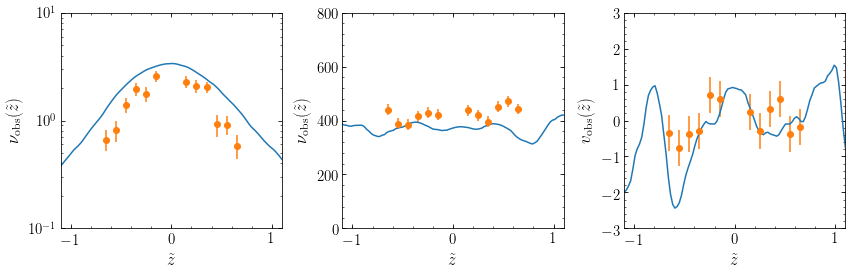

In [73]:
n_m2m= 4000
sigma_init= sigma_true*1.1
h_m2m= 0.2
xnm_m2m = 1.75* xnm_true
# set a wrong omega
omega_m2m = 0.5*omegadm_true
zsun_m2m= zsun_true
z_m2m, vz_m2m, w_init= wendym2m.sample_sech2(sigma_init,totmass_true,n=n_m2m)
z_out= numpy.linspace(zmin, zmax, 101)
dens_init= xnm_m2m*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
v_init= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[densmin, densmax])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,3,2)
bovy_plot.bovy_plot(z_out,v2_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[v2min,v2max])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
subplot(1,3,3)
bovy_plot.bovy_plot(z_out,v_init,'-',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$v_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[vmin,vmax])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
tight_layout()


In [74]:
g = wendypy.nbody(z_m2m, vz_m2m, w_init, 0.01*tdyn, approx=True, nleap=1)
nt = 600
zt = numpy.empty((n_m2m, nt+1))
vzt = numpy.empty((n_m2m, nt+1))
# Et = numpy.empty((nt+1))
zt[:, 0] = z_m2m
vzt[:, 0] = vz_m2m
# Et[0] = wendy.energy(z_init, vz_init, m_init)
# increasing omega
nstep_omega = 500
domega = omega_m2m/nstep_omega
omega_ii = 0.0
tz = z_m2m
tvz = vz_m2m
for ii in tqdm.trange(nt):
    if ii <= nstep_omega:
        g = wendypy.nbody(tz, tvz, w_init, 0.01*tdyn, omega=omega_ii, approx=True, nleap=1)
    tz, tvz= next(g)
    zt[:, ii+1] = tz
    vzt[:, ii+1] = tvz
    # Et[ii+1] = wendy.energy(tz, tvz, m_init, omega=omega_ii)
    # update omega
    if ii < nstep_omega:
        omega_ii += domega
print('Final omega and omega_dm =', omega_ii, omegadm_true)

100%|██████████| 600/600 [00:00<00:00, 2017.59it/s]

Final omega and omega_dm = 15.200000000000088 30.4


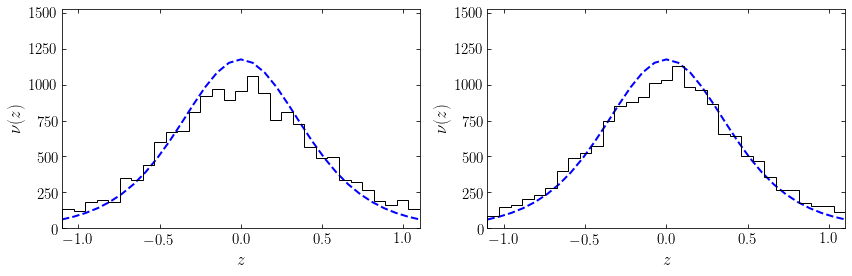

In [75]:
ii = 0
# plot range 
rhomin = 10.**-3.
rhomax = 1.3*totmass_true/(4.0*zh_true)
nbinz = 31
figsize(12,4)
subplot(1,2,1)
_= hist(zt[:,ii], bins=nbinz, histtype='step', lw=1., color='k',
            range=[zmin, zmax],
            weights = numpy.ones(n_m2m)*(totmass_true/n_m2m)*nbinz/(zmax-zmin))
zs = numpy.linspace(zmin, zmax, nbinz)
plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
        'b--', lw=2., zorder=0)
xlim(zmin, zmax)
ylim(rhomin, rhomax)
xlabel(r'$z$')
ylabel(r'$\nu(z)$')
subplot(1,2,2)
_= hist(zt[:,nt], bins=nbinz, histtype='step', lw=1., color='k',
            range=[zmin, zmax],
            weights = numpy.ones(n_m2m)*(totmass_true/n_m2m)*nbinz/(zmax-zmin))
zs = numpy.linspace(zmin, zmax, nbinz)
plot(zs, totmass_true/4./zh_true/numpy.cosh(zs/2./zh_true)**2.,
        'b--', lw=2., zorder=0)
xlim(zmin, zmax)
ylim(rhomin, rhomax)
xlabel(r'$z$')
ylabel(r'$\nu(z)$')

tight_layout()

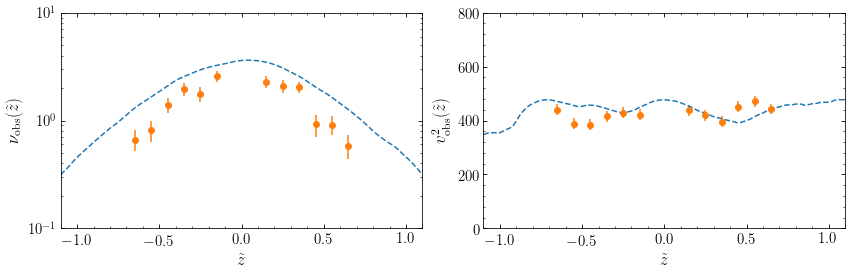

In [76]:
z_m2m = zt[:, nt]
vz_m2m = vzt[:, nt]
z_out= numpy.linspace(zmin, zmax, 101)
dens_init= xnm_m2m*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_init)
v2_init= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
v_init= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(z_out,dens_init,'--',semilogy=True,gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[densmin, densmax])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(1,2,2)
bovy_plot.bovy_plot(z_out,v2_init,'--',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$v^2_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[v2min, v2max])
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])

tight_layout()

In [77]:
# step size for particle integration
step= 0.01*tdyn
nstep= 10000
#eps= 10.**-3.5
# eps = [10.0**-5.0, 10.0**-5.0, 10.0**-7.0]
# eps weight, omega, xnm
eps = [10.0**1.0, 10.0**4.0, 10.0**-7.0]
smooth= None #1./step/100.
st96smooth= False
mu= 0.
h_m2m= 0.2
fit_omega = True
skipomega= 100
skipxnm = 10
fit_xnm = True
prior= 'entropy'
use_v2=True
w_out,omega_out,xnm_out,z_m2m,vz_m2m,Q,wevol,windx= \
    wendym2m.fit_m2m(w_init,z_m2m,vz_m2m,omega_m2m,zsun_m2m,data_dicts,npop=1,
                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,prior=prior,
                     smooth=smooth,st96smooth=st96smooth,output_wevolution=10,
                     fit_omega=fit_omega,skipomega=skipomega,
                     number_density=True, xnm_m2m=xnm_m2m, fit_xnm=fit_xnm, skipxnm=skipxnm)
w_out= w_out[:,0]

 total mass = 1302.0470550372215
 omega fit, true =  29.081451325809006 30.4
 Xnm fit true =  0.001823298378188304 0.002
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)

Velocity dispersions: mock, fit 20.49589949737976 20.900057562650247
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)

/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)



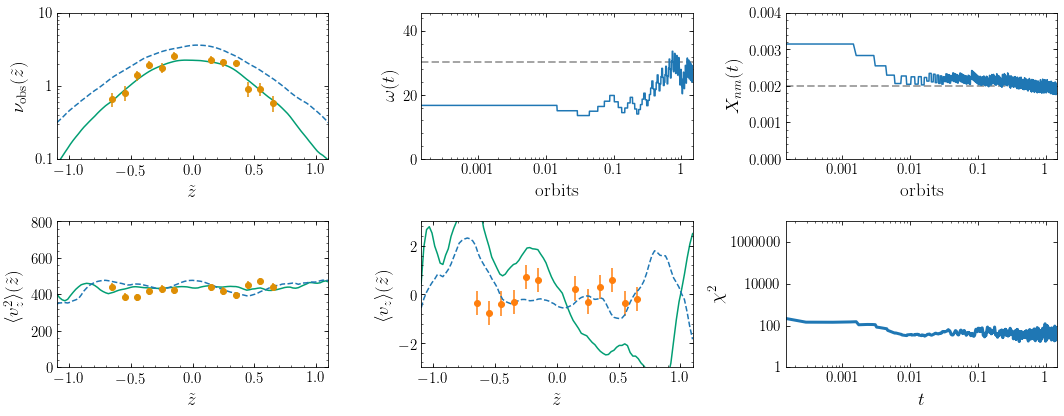

In [78]:
print(' total mass =', numpy.sum(w_out))
print(' omega fit, true = ',omega_out[-1], omegadm_true)
print(' Xnm fit true = ', xnm_out[-1], xnm_true)
z_out= numpy.linspace(zmin, zmax, 101)
dens_final= xnm_out[-1]*hom2m.compute_dens(z_m2m,zsun_true,z_out,h_m2m,w=w_out)
v2_final= hom2m.compute_v2(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
v_final= hom2m.compute_v(z_m2m,vz_m2m,zsun_true,z_out,h_m2m,w=w_out)
bovy_plot.bovy_print(axes_labelsize=19.,text_fontsize=14.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'--',semilogy=True,color=init_color,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[densmin,densmax],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=constraint_color)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0,color=final_color)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=constraint_color)
zs = numpy.linspace(zmin, zmax, 101)
plot(zs, totmass_true/4./zh_true/numpy.cosh((zs+zsun_true)/2./zh_true)**2.,
            'b--', lw=2., zorder=0)
yscale('log',nonposy='clip')
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,4)
bovy_plot.bovy_plot(z_out,v2_init,'--',color=init_color,
                    xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z^2\rangle(\tilde{z})$',
                    xrange=[zmin, zmax],yrange=[v2min,v2max],gcf=True)
bovy_plot.bovy_plot(z_obs,v2_obs,'o',overplot=True,color=constraint_color)                    
bovy_plot.bovy_plot(z_out,v2_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v2_obs,yerr=v2_obs_noise,marker='None',ls='none',color=constraint_color)
# yscale('log',nonposy='clip')
# gca().yaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,2)
# omega evolution
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,omega_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[0.0,1.5*omegadm_true],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$\omega(t)$',gcf=True)
axhline(omegadm_true,ls='--',color='0.65',lw=2.,zorder=0)
gca().xaxis.set_major_formatter(
    FuncFormatter(
        lambda y,pos: 
        (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,5)
# _= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,zorder=0,color=init_color)
# xs= numpy.linspace(zmin, zmax, 201)
# plot(xs,1./numpy.sqrt(2.*numpy.pi)/sigma_true*numpy.exp(-0.5*xs**2./sigma_true**2.),
#     lw=2.,zorder=2,color=constraint_color)
# _= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1,color=final_color)
# xlim(zmin, zmax)
# ylim(0.,2.)
# xlabel(r'$v_z$')
# ylabel(r'$p(v_z)$')
bovy_plot.bovy_plot(z_out,v_init,'--',gcf=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\langle v_z\rangle(\tilde{z})$',
                   xrange=[zmin, zmax],yrange=[vmin,vmax])
bovy_plot.bovy_plot(z_obs,v_obs,'o',overplot=True)
bovy_plot.bovy_plot(z_out,v_final,'-',overplot=True,zorder=0,color=final_color)
errorbar(z_obs,v_obs,yerr=v_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
subplot(2,3,3)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,xnm_out,'-',
                    color=sns.color_palette()[0],
                    yrange=[0.0, 2.0*xnm_true],
                    semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$X_{nm}(t)$',gcf=True)
axhline(xnm_true,ls='--',color='0.65',lw=2.,zorder=0)
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
# for ii in range(len(wevol)):
#    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,wevol[ii,0],'-',
#                        color=cm.viridis(z_m2m[windx][ii]/0.3),
#                        yrange=[-0.2/len(z_m2m),numpy.amax(wevol)*1.1],
#                        semilogx=True,xlabel=r'$t$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
#gca().xaxis.set_major_formatter(FuncFormatter(
#                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$t$',ylabel=r'$\chi^2$',gcf=True,
                   yrange=[1.,10**7.0])
gca().yaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
gca().xaxis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
tight_layout()

In [38]:
savefilename= 'xnmomega_rhov2obs_data.sav' 
# if os.path.exists(savefilename):
#    with open(savefilename,'rb') as savefile:
#        out= (pickle.load(savefile),)
#        while True:
#            try:
#                out= out+(pickle.load(savefile),)
#            except EOFError:
#                break
#    w_out,z_m2m,vz_m2m,omega_m2m,xnm_m2m,zsun_m2m,data_dicts,w_init= out
# else:
save_pickles(savefilename,w_out,omega_out,xnm_out,z_m2m,vz_m2m,omegadm_true,xnm_true,zsun_true,totmass_true,
             zh_true,sigma_true,data_dicts,z_mock,vz_mock,v_obs,\
             w_init,h_m2m,omega_m2m,xnm_m2m,zsun_m2m,\
             dens_init,v2_init,v_init,\
             nstep,step,tdyn,eps,Q,wevol,windx)